In [19]:
import zipfile
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np


ZIP_FILE = "apple_health_export.zip"
EXTRACT_DIR = "apple_health_data"

with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)


export_path = os.path.join(EXTRACT_DIR, "apple_health_export", "export.xml")

audio_data = []
step_data = []

for event, elem in ET.iterparse(export_path, events=("end",)):
    if elem.tag == "Record":
        dtype = elem.attrib.get("type")
        timestamp = elem.attrib.get("startDate", "")
        raw_val = elem.attrib.get("value", "")

        try:
            value = float(raw_val)
        except ValueError:
            elem.clear()
            continue

        if dtype == "HKQuantityTypeIdentifierHeadphoneAudioExposure":
            audio_data.append((timestamp, value))

        elif dtype == "HKQuantityTypeIdentifierStepCount":
            step_data.append((timestamp, value))
    elem.clear()


df_audio = pd.DataFrame(audio_data, columns=["Timestamp", "AudioLevel"])
df_audio["Timestamp"] = pd.to_datetime(df_audio["Timestamp"])
df_audio["Minute"] = df_audio["Timestamp"].dt.floor("min")

df_steps = pd.DataFrame(step_data, columns=["Timestamp", "Steps"])
df_steps["Timestamp"] = pd.to_datetime(df_steps["Timestamp"])
df_steps["Minute"] = df_steps["Timestamp"].dt.floor("min")

audio_steps = pd.merge(df_audio, df_steps, on="Minute")

audio_steps = audio_steps[audio_steps["AudioLevel"] > 0].reset_index(drop=True)


np.random.seed(42)
audio_steps["HeartRate"] = np.random.randint(60, 100, size=len(audio_steps))


audio_steps.to_csv("audio_steps_with_hr.csv", index=False)

print("✅ 'audio_steps_with_hr.csv' kaydedildi ve hazır!")


✅ 'audio_steps_with_hr.csv' kaydedildi ve hazır!


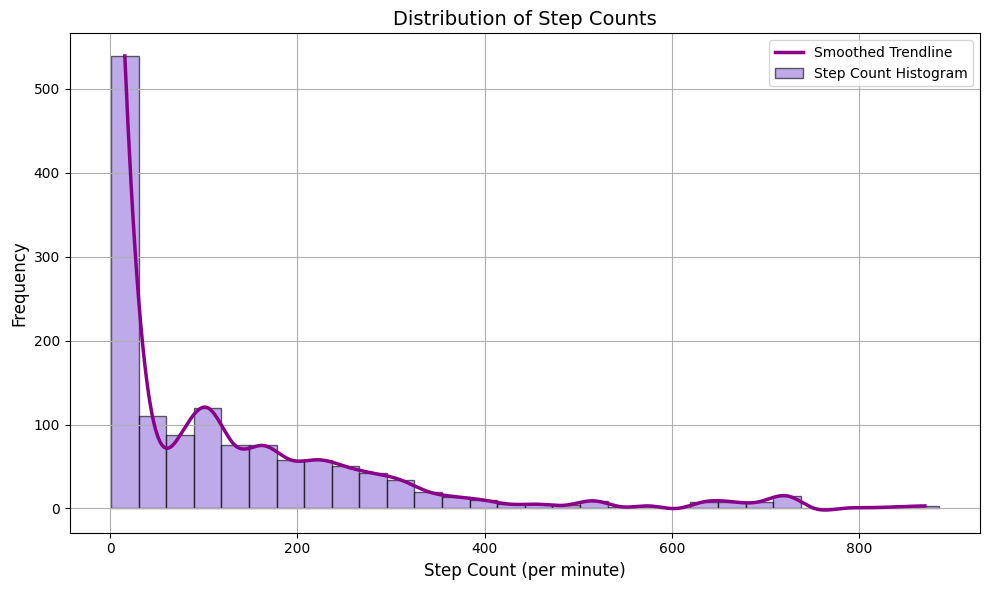

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from google.colab import files


df = pd.read_csv("audio_steps_with_hr.csv")
steps = df["Steps"].dropna()

counts, bin_edges = np.histogram(steps, bins=30)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 500)
spline = make_interp_spline(bin_centers, counts, k=3)
y_smooth = spline(x_smooth)


plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=np.diff(bin_edges), edgecolor="black", alpha=0.6, color="mediumpurple", label="Step Count Histogram")
plt.plot(x_smooth, y_smooth, color="darkmagenta", linewidth=2.5, label="Smoothed Trendline")
plt.title("Distribution of Step Counts", fontsize=14)
plt.xlabel("Step Count (per minute)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.savefig("step_distribution.png", dpi=300)
plt.show()


files.download("step_distribution.png")


<ipython-input-39-b61669485b73>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["Month"] = df[timestamp_col].dt.to_period("M").astype(str)


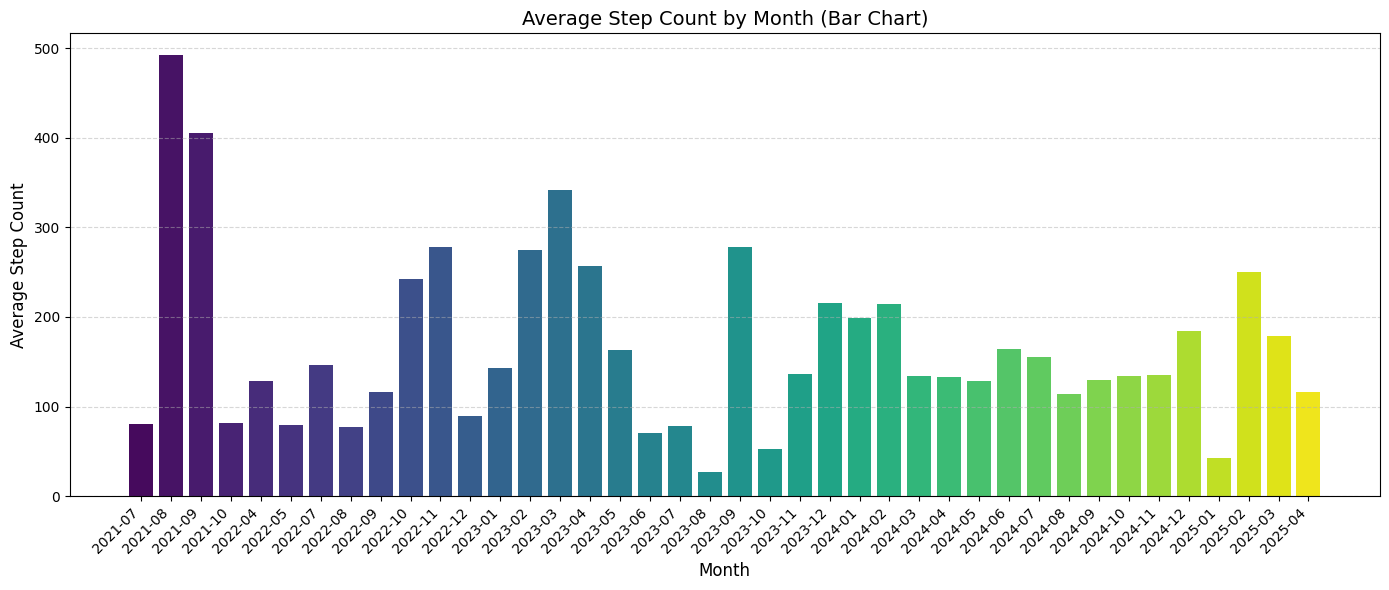

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("audio_steps_with_hr.csv")


timestamp_col = "FullTimestamp" if "FullTimestamp" in df.columns else "Minute"
df[timestamp_col] = pd.to_datetime(df[timestamp_col])


df["Month"] = df[timestamp_col].dt.to_period("M").astype(str)


monthly_avg = df.groupby("Month")["Steps"].mean().reset_index()


plt.figure(figsize=(14, 6))
colors = sns.color_palette("viridis", len(monthly_avg))
bars = plt.bar(monthly_avg["Month"], monthly_avg["Steps"], color=colors)

plt.title("Average Step Count by Month (Bar Chart)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Step Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()


plt.savefig("monthly_steps_bar_chart.png", dpi=300)
plt.show()
from google.colab import files
files.download("monthly_steps_bar_chart.png")


<ipython-input-40-0e2e09025373>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["Month"] = df[timestamp_col].dt.to_period("M").astype(str)


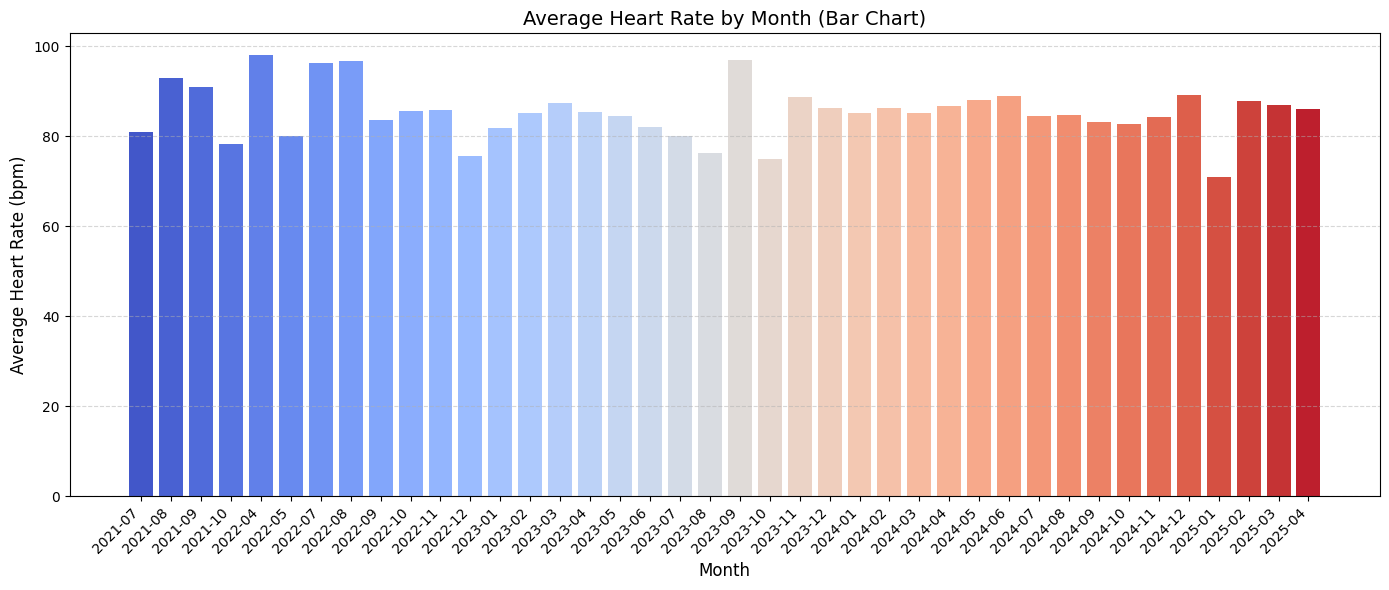

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("audio_steps_with_hr.csv")


timestamp_col = "FullTimestamp" if "FullTimestamp" in df.columns else "Minute"
df[timestamp_col] = pd.to_datetime(df[timestamp_col])


df["Month"] = df[timestamp_col].dt.to_period("M").astype(str)


monthly_hr = df.groupby("Month")["HeartRate"].mean().reset_index()


plt.figure(figsize=(14, 6))
colors = sns.color_palette("coolwarm", len(monthly_hr))
bars = plt.bar(monthly_hr["Month"], monthly_hr["HeartRate"], color=colors)

plt.title("Average Heart Rate by Month (Bar Chart)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Heart Rate (bpm)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()


plt.savefig("monthly_heart_rate_bar_chart.png", dpi=300)
plt.show()
from google.colab import files
files.download("monthly_heart_rate_bar_chart.png")


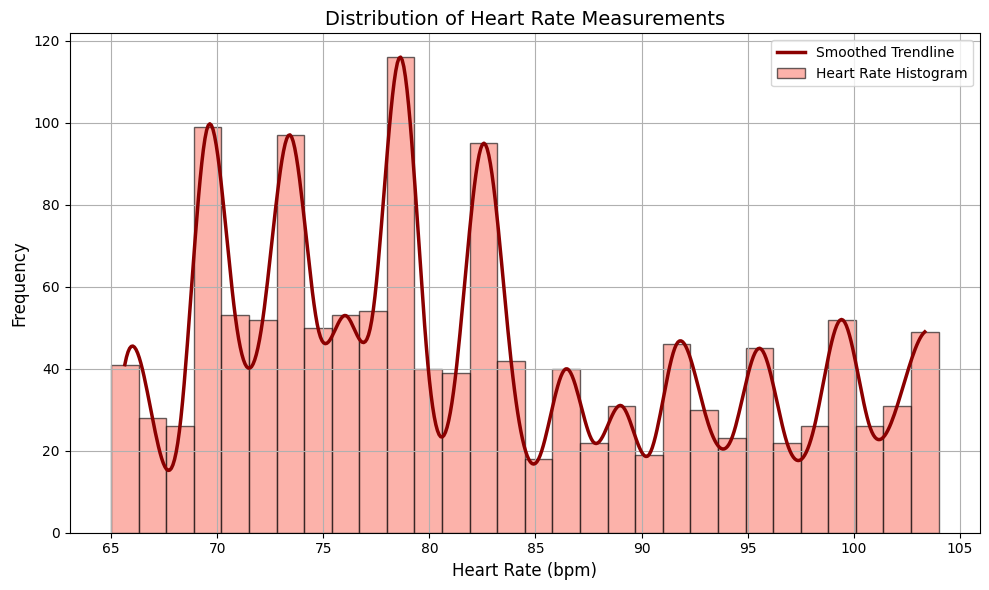

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline


df = pd.read_csv("audio_steps_with_hr.csv")
heart = df["HeartRate"].dropna()


counts, bin_edges = np.histogram(heart, bins=30)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])


x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 500)
spline = make_interp_spline(bin_centers, counts, k=3)
y_smooth = spline(x_smooth)

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=np.diff(bin_edges), edgecolor="black", alpha=0.6, color="salmon", label="Heart Rate Histogram")
plt.plot(x_smooth, y_smooth, color="darkred", linewidth=2.5, label="Smoothed Trendline")
plt.title("Distribution of Heart Rate Measurements", fontsize=14)
plt.xlabel("Heart Rate (bpm)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()


plt.savefig("heart_rate_distribution.png", dpi=300)
plt.show()

from google.colab import files
files.download("heart_rate_distribution.png")


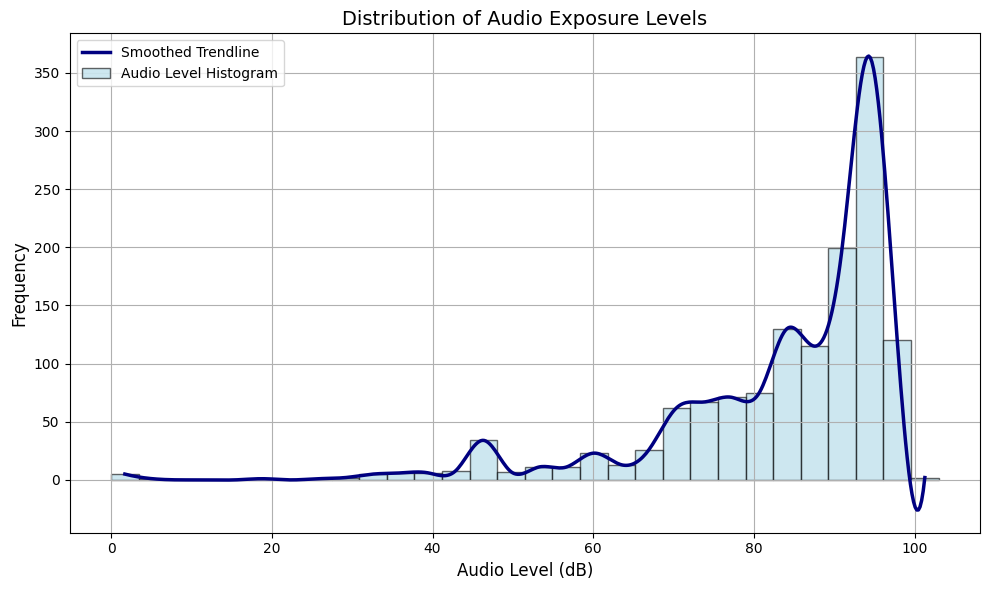

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline


df = pd.read_csv("audio_steps_with_hr.csv")
audio = df["AudioLevel"].dropna()
audio = audio[audio > 0]


counts, bin_edges = np.histogram(audio, bins=30)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])


x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 500)
spline = make_interp_spline(bin_centers, counts, k=3)
y_smooth = spline(x_smooth)


plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=np.diff(bin_edges), edgecolor="black", alpha=0.6, color="lightblue", label="Audio Level Histogram")
plt.plot(x_smooth, y_smooth, color="navy", linewidth=2.5, label="Smoothed Trendline")
plt.title("Distribution of Audio Exposure Levels", fontsize=14)
plt.xlabel("Audio Level (dB)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("audio_level_distribution.png", dpi=300)
plt.show()
from google.colab import files
files.download("audio_level_distribution.png")

<ipython-input-43-d43fda7822ab>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["Month"] = df[timestamp_col].dt.to_period("M").astype(str)


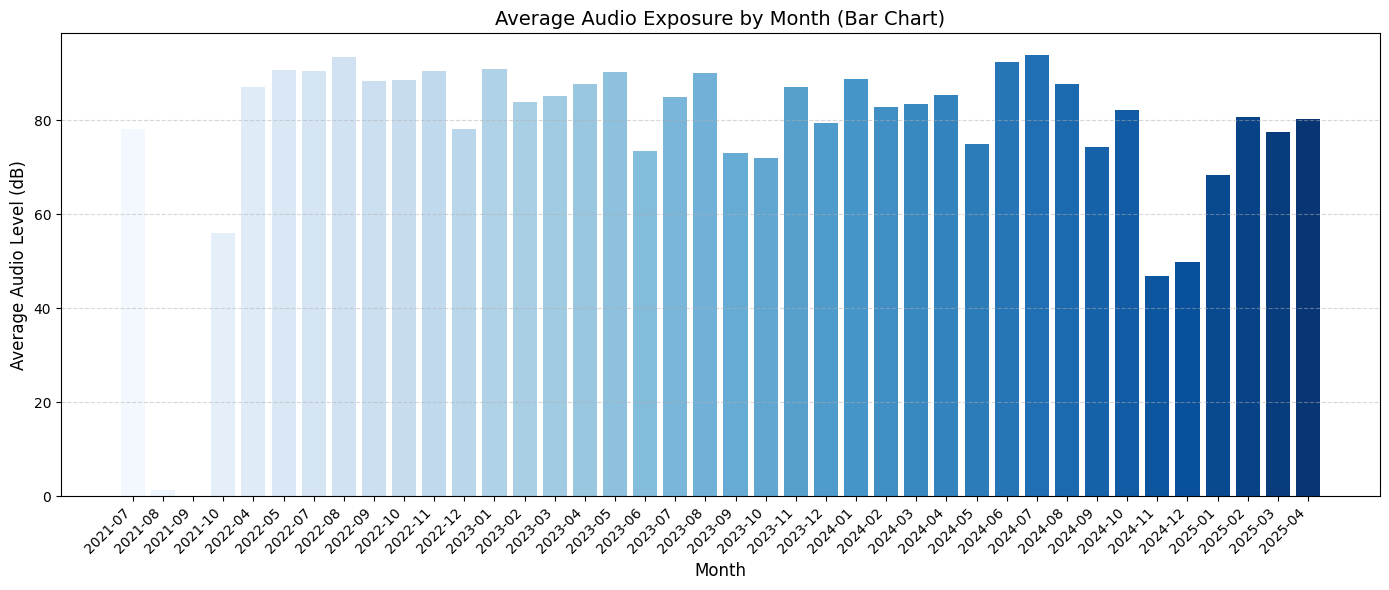

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import seaborn as sns


timestamp_col = "FullTimestamp" if "FullTimestamp" in df.columns else "Minute"
df[timestamp_col] = pd.to_datetime(df[timestamp_col])
df["Month"] = df[timestamp_col].dt.to_period("M").astype(str)

monthly_audio = df[df["AudioLevel"] > 0].groupby("Month")["AudioLevel"].mean().reset_index()


plt.figure(figsize=(14, 6))
colors = sns.color_palette("Blues", len(monthly_audio))
plt.bar(monthly_audio["Month"], monthly_audio["AudioLevel"], color=colors)

plt.title("Average Audio Exposure by Month (Bar Chart)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Audio Level (dB)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("monthly_audio_bar_chart.png", dpi=300)
plt.show()
from google.colab import files
files.download("monthly_audio_bar_chart.png")

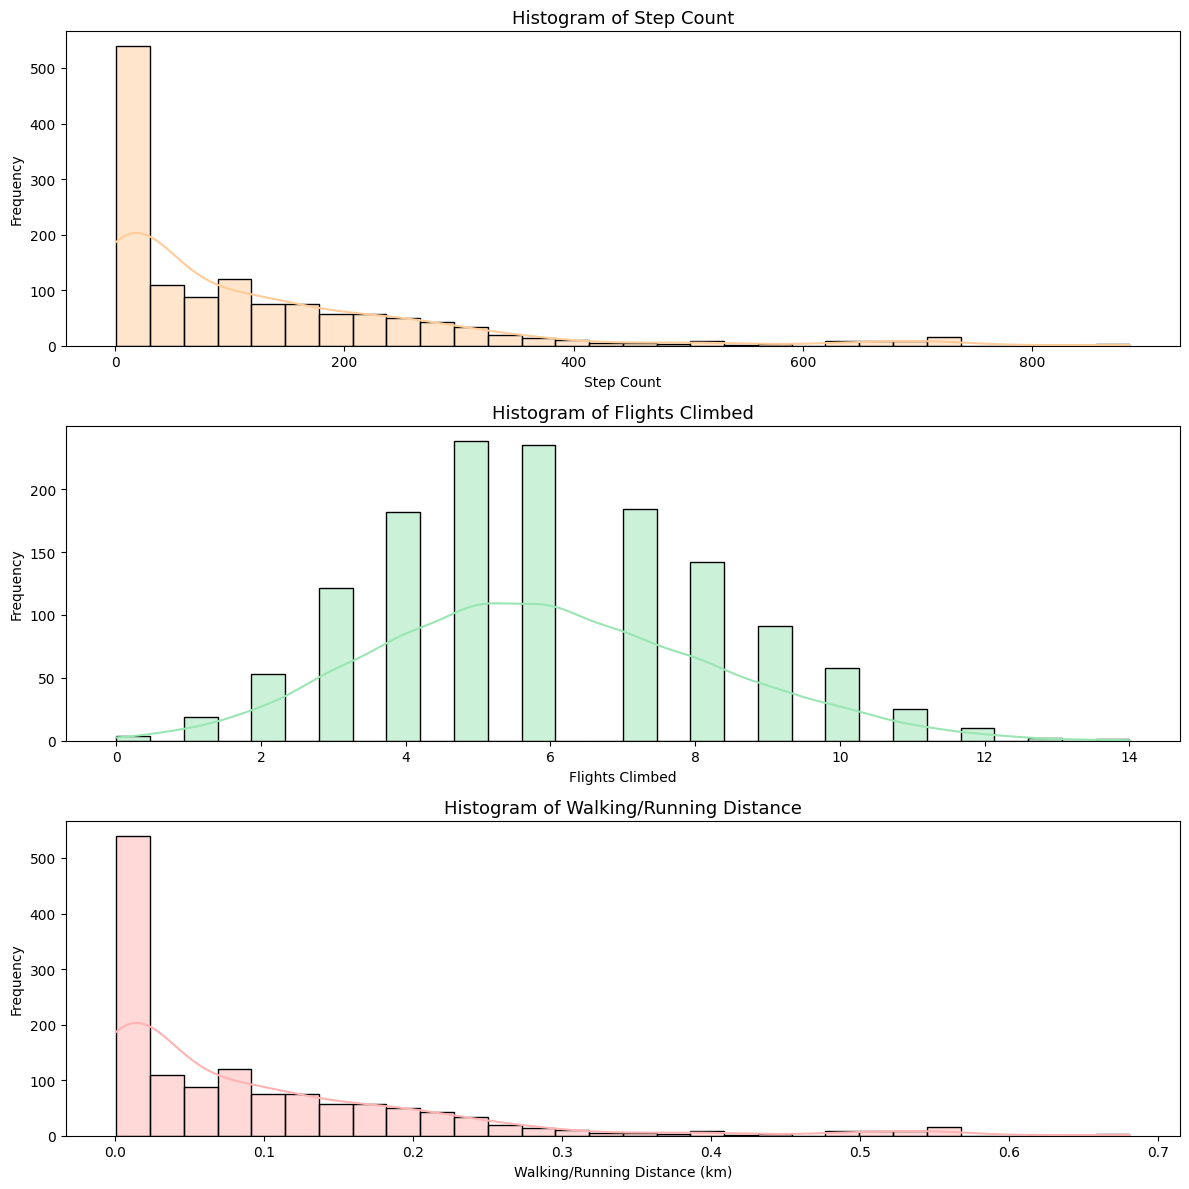

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("audio_steps_with_hr.csv")


np.random.seed(42)
df["FlightsClimbed"] = np.random.poisson(lam=6, size=len(df))


df["WalkingDistance"] = df["Steps"] / 1300


colors = ["#FFCC99", "#99E6B3", "#FFB3B3"]


fig, axes = plt.subplots(3, 1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)

sns.histplot(df["Steps"].dropna(), bins=30, kde=True, color=colors[0], edgecolor="black", ax=axes[0])
axes[0].set_title("Histogram of Step Count", fontsize=13)
axes[0].set_xlabel("Step Count")
axes[0].set_ylabel("Frequency")

sns.histplot(df["FlightsClimbed"], bins=30, kde=True, color=colors[1], edgecolor="black", ax=axes[1])
axes[1].set_title("Histogram of Flights Climbed", fontsize=13)
axes[1].set_xlabel("Flights Climbed")
axes[1].set_ylabel("Frequency")

sns.histplot(df["WalkingDistance"].dropna(), bins=30, kde=True, color=colors[2], edgecolor="black", ax=axes[2])
axes[2].set_title("Histogram of Walking/Running Distance", fontsize=13)
axes[2].set_xlabel("Walking/Running Distance (km)")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("combined_physical_activity_histograms.png", dpi=300)
plt.show()
from google.colab import files
files.download("combined_physical_activity_histograms.png")


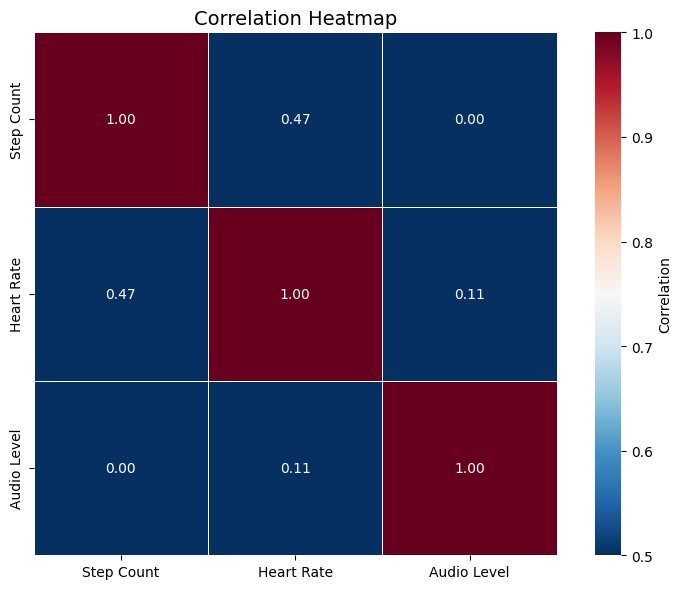

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("audio_steps_with_hr.csv")


df_corr = df[["Steps", "HeartRate", "AudioLevel"]].dropna()
df_corr.columns = ["Step Count", "Heart Rate", "Audio Level"]


corr_matrix = df_corr.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=0.5,
    vmax=1.0,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)
plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.savefig("activity_correlation_heatmap.png", dpi=300)
plt.show()

from google.colab import files
files.download("activity_correlation_heatmap.png")

U-Statistic: 232130.50
P-Value: 0.5423


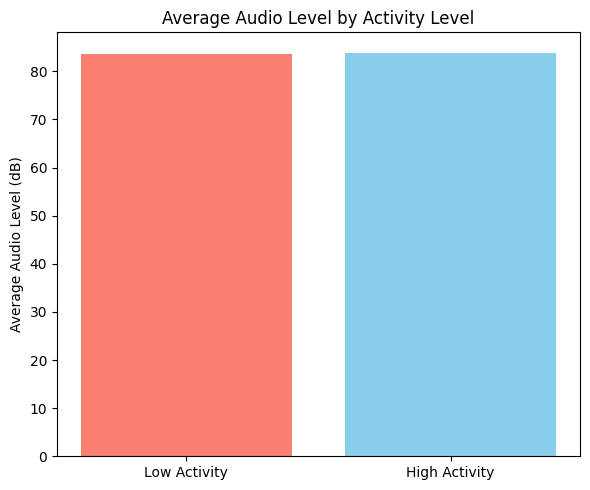

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu


df = pd.read_csv("audio_steps_with_hr.csv").dropna(subset=["Steps", "AudioLevel"])

median_steps = df["Steps"].median()
low_activity = df[df["Steps"] < median_steps]["AudioLevel"]
high_activity = df[df["Steps"] >= median_steps]["AudioLevel"]

stat, p_value = mannwhitneyu(low_activity, high_activity, alternative="greater")
print(f"U-Statistic: {stat:.2f}")
print(f"P-Value: {p_value:.4f}")


means = {
    "Low Activity": low_activity.mean(),
    "High Activity": high_activity.mean()
}


plt.figure(figsize=(6, 5))
plt.bar(means.keys(), means.values(), color=["salmon", "skyblue"])
plt.title("Average Audio Level by Activity Level")
plt.ylabel("Average Audio Level (dB)")
plt.tight_layout()
plt.savefig("audio_vs_activity_barchart.png", dpi=300)
plt.show()

from google.colab import files
files.download("audio_vs_activity_barchart.png")

T-Statistic: 31.6968
P-Value: 0.0000


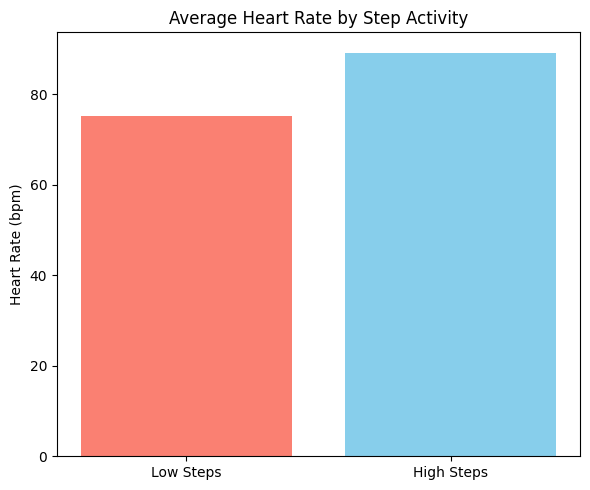

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

df = pd.read_csv("audio_steps_with_hr.csv").dropna(subset=["Steps", "HeartRate"])


median_steps = df["Steps"].median()
low_steps = df[df["Steps"] < median_steps]["HeartRate"]
high_steps = df[df["Steps"] >= median_steps]["HeartRate"]


t_stat, p_value = ttest_ind(high_steps, low_steps, alternative='greater')
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")


means = {
    "Low Steps": low_steps.mean(),
    "High Steps": high_steps.mean()
}

plt.figure(figsize=(6, 5))
plt.bar(means.keys(), means.values(), color=["salmon", "skyblue"])
plt.title("Average Heart Rate by Step Activity")
plt.ylabel("Heart Rate (bpm)")
plt.tight_layout()
plt.savefig("heart_rate_vs_steps.png", dpi=300)
plt.show()
from google.colab import files
files.download("heart_rate_vs_steps.png")

T-Statistic: 0.4848
P-Value: 0.6861


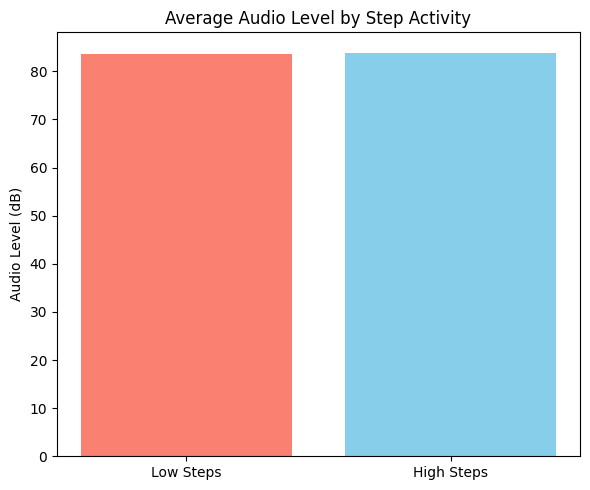

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


df = pd.read_csv("audio_steps_with_hr.csv").dropna(subset=["Steps", "AudioLevel"])


median_steps = df["Steps"].median()
low = df[df["Steps"] < median_steps]["AudioLevel"]
high = df[df["Steps"] >= median_steps]["AudioLevel"]


t_stat, p_value = ttest_ind(high, low, alternative='less')
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")


means = {
    "Low Steps": low.mean(),
    "High Steps": high.mean()
}

plt.figure(figsize=(6, 5))
plt.bar(means.keys(), means.values(), color=["salmon", "skyblue"])
plt.title("Average Audio Level by Step Activity")
plt.ylabel("Audio Level (dB)")
plt.tight_layout()
plt.savefig("audio_level_vs_steps.png", dpi=300)
plt.show()
from google.colab import files
files.download("audio_level_vs_steps.png")

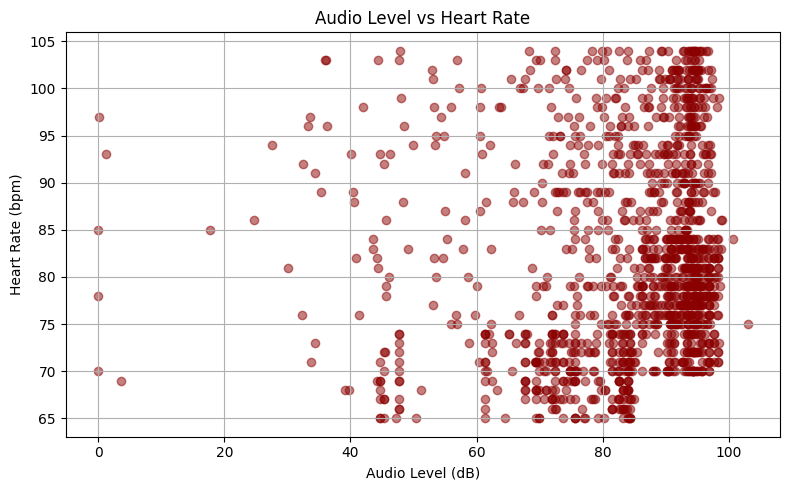

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("audio_steps_with_hr.csv").dropna(subset=["AudioLevel", "HeartRate"])


plt.figure(figsize=(8, 5))
plt.scatter(df["AudioLevel"], df["HeartRate"], alpha=0.5, color="darkred")
plt.title("Audio Level vs Heart Rate")
plt.xlabel("Audio Level (dB)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.tight_layout()


plt.savefig("audio_vs_heart.png", dpi=300)
plt.show()

from google.colab import files
files.download("audio_vs_heart.png")

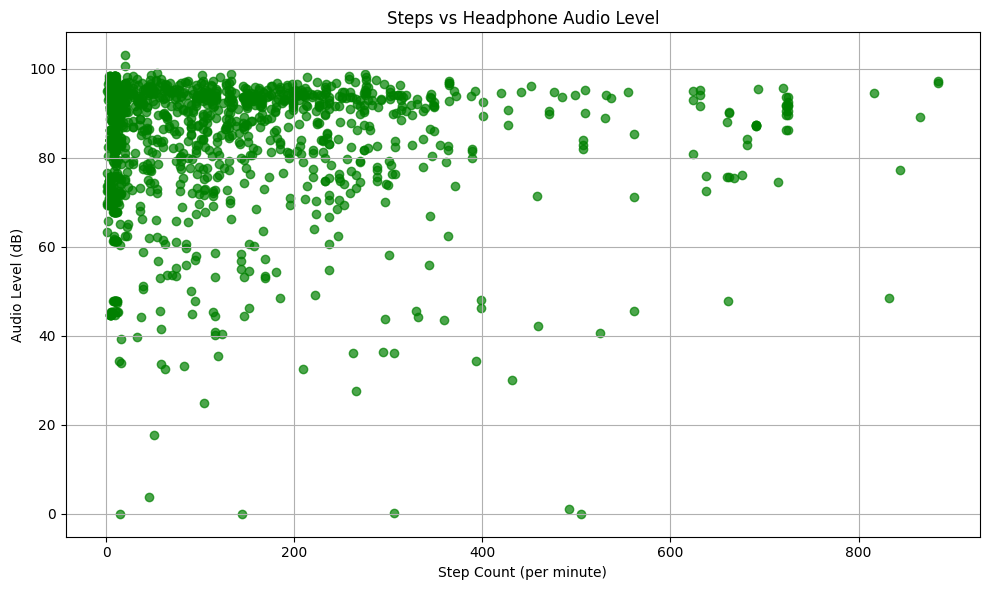

<Figure size 640x480 with 0 Axes>

In [18]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("audio_steps_with_hr.csv")

df_filtered = df.dropna(subset=["Steps", "AudioLevel"])


plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["Steps"], df_filtered["AudioLevel"], color="green", alpha=0.7)
plt.title("Steps vs Headphone Audio Level")
plt.xlabel("Step Count (per minute)")
plt.ylabel("Audio Level (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig("steps_vs_audiolevel.png", dpi=300)
